# Imports and Functions

In [1]:
import math 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton
import matplotlib.path as path
from matplotlib.colors import ListedColormap
import numpy as np
from numpy import load
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neighbors import KDTree
from sklearn.svm import SVC
%matplotlib notebook

global selection_model

import random
from random import randint

global cm
global cm_bright
global wales
global maxiter
global numcoords
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

wales = load('walesoutline1.npy')
wales = path.Path(wales)


maxiter = 21
numcoords = 2
selection_model = 4 #0 for 0.5, 1 for isolated, 2 for random, 3 for best, 4 for sim_anneal

global threshold
threshold = 20 

In [2]:
import math
def normpdf(x, mean, sd):
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

In [3]:
def calculateModel():
    
    global X
    global Z
    global Z_model_pred
    global Znew
    global Zbranin
    global xx,yy
    global Big_df
    global Big_df_land
    global clf


    x_min, x_max = -5, 51 
    y_min, y_max = -2, 53
    h = .5  # step size in the mesh

    Coords_df = pd.DataFrame(coords,columns=['XPos','YPos','Type'])
    DT_X_Values = Coords_df.drop(['Type'],axis=1)

    X = DT_X_Values.to_numpy().tolist()
    X = np.array(X)

    DT_Y_Values = Coords_df.drop(['XPos'],axis=1)
    DT_Y_Values = DT_Y_Values.drop(['YPos'],axis=1)
    y = DT_Y_Values.to_numpy().ravel()



    clf = SVC(probability=True, gamma = 0.01)
    clf.fit(X, y)
    
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
    
    Zbranin = []
    branincoords = np.c_[xx.ravel(), yy.ravel()]
    for i in range(12320):
        Zbranin.append(braninColor(branincoords[i],threshold))



    Z_model_prob = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z_model_prob = Z_model_prob.reshape(xx.shape)                                                      #Z is [model_probs]
    Z_model_pred = clf.predict(np.c_[xx.ravel(), yy.ravel()])[:]                        #Z_model_pred is [model_predictions]

    Big_df = pd.DataFrame(xx.ravel(), columns=['xx'])#
    Big_df.insert(1, 'yy',yy.ravel())
    Big_df.insert(2, 'Z_model_predictions', Z_model_pred.ravel())
    Big_df.insert(3, 'Z_model_predictions_flattened', 0)
    Big_df.insert(4, 'Z_model_probs', Z_model_prob.ravel())
    Big_df.insert(5, 'Z_model_probs_flattened_SEA', 0)
    Big_df.insert(6, 'Z_model_probs_flattened_0', 0)
    Big_df.insert(7, 'Surrogate_model_predictions', Zbranin)
    Big_df.insert(8, 'Surrogate_model_predictions_flattened', 0)

    for i in range(12320):

        if (wales.contains_points([(Big_df.iat[i,0],Big_df.iat[i,1])])[0]):
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_probs']
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = Big_df.iloc[i]['Surrogate_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = Big_df.iloc[i]['Z_model_probs']

        else:
            Big_df.loc[i, 'Z_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = 'SEA'
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = 0

    Z_model_predictions = Big_df["Z_model_predictions"].to_numpy()
    Z_model_predictions_flattened = Big_df["Z_model_predictions_flattened"].to_numpy()
    Z_model_probs = Big_df["Z_model_probs"].to_numpy()
#     Z_model_probs_flattened = Big_df["Z_model_probs_flattened"].to_numpy()
    Surrogate_model_predictions = Big_df["Surrogate_model_predictions"].to_numpy()
    Surrogate_model_predictions_flattened = Big_df["Surrogate_model_predictions_flattened"].to_numpy()

    Big_df_land = Big_df[Big_df['Z_model_predictions_flattened'] != 'SEA']

    Contour_model = Big_df["Z_model_probs_flattened_0"].to_numpy()
    Contour_model = Contour_model.reshape(xx.shape) 


    plt.cla()
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic_r')
    # plt.axis("off")
    plt.grid()
    ax.contourf(xx, yy, Contour_model, 40, cmap=cm, alpha=
                0.4)

    plt.plot()

    plt.show()


In [4]:
def StaticPen(x):

    if(wales.contains_point(x)):
        pen = 1
    else:
        pen = 0

    dist = (tree.query([x], k=1)[0])
    prob = clf.predict_proba([x])[0][0]
    tmp_score = (0.5-np.abs(0.5-prob))*dist

    return tmp_score*pen

def sim_anneal_best():
    
    global tree
    
    tree = KDTree(X, leaf_size=40)

    lower_bound = np.array([-5,-2])
    upper_bound = np.array([51,53])
    max_iter = 1000
    stdevscale = 0.2*(upper_bound-lower_bound)
    gamma = 0.35
    t_initial = 1000
    r = 100
    beta = 1

    import math
    from scipy.stats import truncnorm
    global Xdash,Ydash




    Xbest = np.random.uniform(low  = lower_bound,    
                          high = upper_bound,        
                          size = (len(lower_bound)))

    Ybest = StaticPen(Xbest)
    Xcenter = Xbest                                          
    Ycenter = Ybest
    t_k=t_initial

    for k in range(max_iter-1):  

        Xdash = truncnorm.rvs((lower_bound - Xcenter)/stdevscale,(upper_bound-Xcenter)    
                              /stdevscale,loc=Xcenter,scale=stdevscale)          

        Ydash = StaticPen(Xdash)
        deltaY = Ydash - Ycenter

        if deltaY<=0 or np.random.rand()<min((math.exp(-deltaY/t_k)),1):
            Xcenter = Xdash
            Ycenter = Ydash                               

            if Ydash>Ybest:
                Xbest=Xdash
                Ybest=Ydash

                t_k = t_k*gamma    

    ax.scatter(Xbest[0],Xbest[1], c='#00FF00', s=25)
    plt.plot()
    plt.show()
    fig1.show()
    print('sim_anneal_isolated coord:',(Xbest[0],Xbest[1]),'distance:',Ybest)
    
    return np.array([Xbest[0],Xbest[1]])

In [5]:
def find_isolated_point():
       
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]

    testpoints = tmp_df[['xx','yy']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        if dist>maxdist:
            maxdist = dist
            maxind = ind
            ifinal = i

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)
    plt.plot()
    plt.show()
    fig1.show()
#     print('isolated', testpoints[ifinal])
    return testpoints[ifinal]
    
def find0_5():
    
    tmp_df = Big_df.iloc[(Big_df['Z_model_probs_flattened_0']-0.50).abs().argsort()[:2]]
    value = randint(0, len(tmp_df.index)-1)
    uncertain_coord = [tmp_df.iloc[value]['xx'],tmp_df.iloc[value]['yy']]
        
    ax.scatter(uncertain_coord[0], uncertain_coord[1], c='#00FF00', s=25)
    plt.plot()
    plt.show()    
    fig1.show()
      
#     print('0_5', uncertain_coord)
    return uncertain_coord

def random_point():
    
    tmp_df = Big_df_land.iloc[:, :]
    testpoints = tmp_df[['xx','yy']].to_numpy()
                    
    ifinal = randint(0,len(testpoints.tolist()))
    
    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()
    
    fig1.show()
    
    return testpoints[ifinal]

def best():
    
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]
    score = 0

    testpoints = tmp_df[['xx','yy']].to_numpy()
    testpoints1 = tmp_df[['Z_model_probs']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        prob = testpoints1[i]
        tmp_score = dist*normpdf(prob,0.5,0.05)
        if tmp_score>score:
            ifinal = i
            distfinal = dist
            probfinal = prob
            score = tmp_score

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()

    fig1.show()
    
    find0_5()
    find_isolated_point()
    
    print(distfinal)
    print(probfinal)
    print(score)
    print('best',testpoints[ifinal])

    return testpoints[ifinal]
    
    



In [6]:
def Accuracy():
    
    correctPredictions = 0
    incorrectPredictions = 0

    for i in range(len(Big_df_land.index)):
        if ((Big_df_land.iloc[i]["Z_model_predictions"])==(Big_df_land.iloc[i]["Surrogate_model_predictions"])):
            correctPredictions+=1
        else:
            incorrectPredictions+=1


    accuracy = (correctPredictions)/((
    incorrectPredictions+correctPredictions))
    accuracyArray.append(accuracy)

    print('Accuracy is',accuracy)
    

def printGraph():
    
    xAxis = []
    for i in range(len(accuracyArray)):
        xAxis.append(i+1)

    plt.scatter(xAxis, accuracyArray) 
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy over time')
    plt.ylim(0.3, 1.0)  
    plt.show()

In [7]:
def xnew(x): 
    return (-5)+(((x+5)*(10+5))/(51+5))
def ynew(y): 
    return ((y+2)*(15))/(55)

def branin(x, a=1, b=5.1/(4*(np.pi**2)), c=5/np.pi, r=6, s=10, t=1/(8*np.pi), noise=0.1):
       
    return a*(x[1]-(b*(x[0]**2))+c*x[0]-r)**2+(s*(1-t)*np.cos(x[0]))+s

def braninColor(x, threshold):
    
    if branin((xnew(x[0]),xnew(x[1])))>threshold:
        return 1
    else:
        return 0

# Plot first graph

experiment:  0


<IPython.core.display.Javascript object>


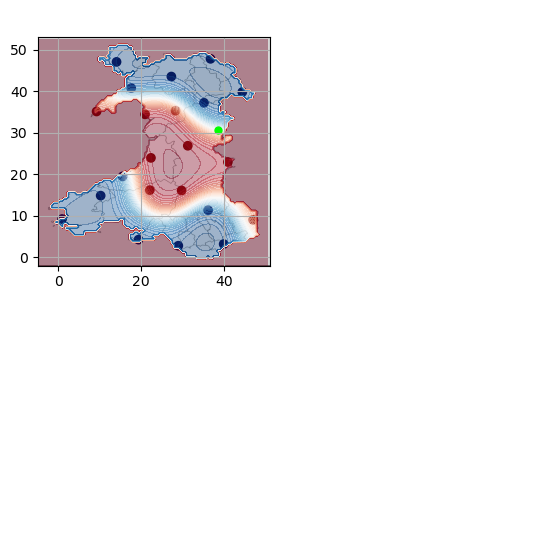

iteration  1
Accuracy is 0.5779657758123438
sim_anneal_isolated coord: (0.9098677496412844, 9.226821255525742) distance: [[17.53256381]]
iteration  2
Accuracy is 0.6594885598923284
sim_anneal_isolated coord: (9.22954086837411, 35.13907543165824) distance: [[9.33095556]]
iteration  3
Accuracy is 0.7164006921745818
sim_anneal_isolated coord: (28.917171965031624, 2.8074871373953423) distance: [[12.0947764]]
iteration  4
Accuracy is 0.6979427033262834
sim_anneal_isolated coord: (46.92777637606094, 9.050719973810128) distance: [[9.53099978]]
iteration  5
Accuracy is 0.7238992501442031
sim_anneal_isolated coord: (22.04526401414406, 16.193764556691804) distance: [[6.58954358]]
iteration  6
Accuracy is 0.617958084983657
sim_anneal_isolated coord: (44.335110240465866, 39.81918763052801) distance: [[6.26516235]]
iteration  7
Accuracy is 0.7281292059219381
sim_anneal_isolated coord: (14.03837625313625, 47.08332080172703) distance: [[6.26773389]]
iteration  8
Accuracy is 0.7629302057296674
sim_ann

<IPython.core.display.Javascript object>


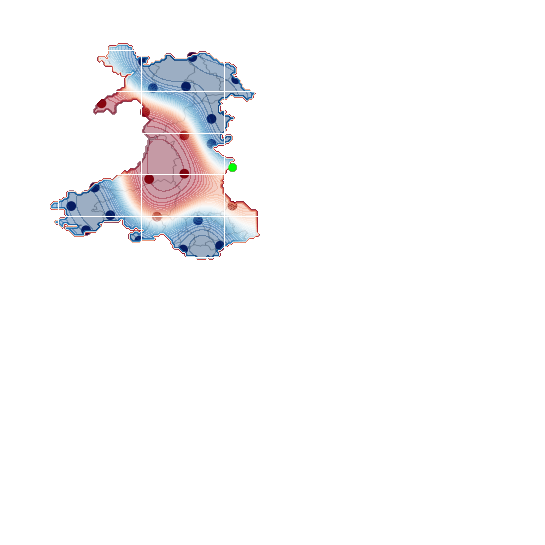

iteration  1
Accuracy is 0.505095174004999
sim_anneal_isolated coord: (20.428014722010694, 47.18634697575472) distance: [[20.43388009]]
iteration  2
Accuracy is 0.634108825225918
sim_anneal_isolated coord: (3.126993413311409, 12.355101671435673) distance: [[13.72368036]]
iteration  3
Accuracy is 0.6319938473370506
sim_anneal_isolated coord: (21.882674160690524, 18.861053647800812) distance: [[6.71769405]]
iteration  4
Accuracy is 0.7661988079215536
sim_anneal_isolated coord: (42.85243586400102, 42.911814919498724) distance: [[11.24899231]]
iteration  5
Accuracy is 0.7435108632955201
sim_anneal_isolated coord: (36.8973445994736, 27.34211236908779) distance: [[6.05551448]]
iteration  6
Accuracy is 0.6792924437608152
sim_anneal_isolated coord: (30.76614343417136, 41.14849338680526) distance: [[5.10490701]]
iteration  7
Accuracy is 0.6792924437608152
sim_anneal_isolated coord: (10.425639314661282, 37.09910536417187) distance: [[3.79298009]]
iteration  8
Accuracy is 0.7046721784272255
sim_a

<IPython.core.display.Javascript object>


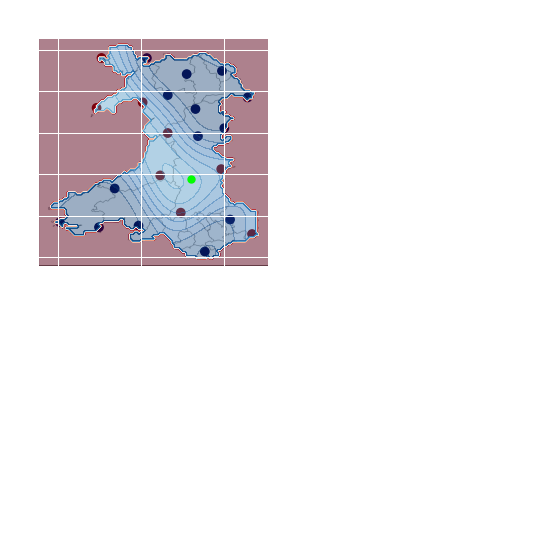

iteration  1
Accuracy is 0.4443376273793501
sim_anneal_isolated coord: (21.349313316383654, 48.00478028280689) distance: [[19.05495851]]
iteration  2
Accuracy is 0.6858296481445876
sim_anneal_isolated coord: (0.3964722282704929, 8.47446607856473) distance: [[14.13349071]]
iteration  3
Accuracy is 0.6542972505287444
sim_anneal_isolated coord: (45.61763171395239, 38.52792890645594) distance: [[9.81174672]]
iteration  4
Accuracy is 0.6400692174581811
sim_anneal_isolated coord: (26.370711043816897, 29.952622156473574) distance: [[5.48919206]]
iteration  5
Accuracy is 0.8323399346279562
sim_anneal_isolated coord: (9.231256063017792, 36.01222850201656) distance: [[6.09711248]]
iteration  6
Accuracy is 0.8425302826379543
sim_anneal_isolated coord: (13.594073324411198, 16.590059526940472) distance: [[7.56125862]]
iteration  7
Accuracy is 0.8323399346279562
sim_anneal_isolated coord: (39.992752081352556, 31.119781862561673) distance: [[4.50994622]]
iteration  8
Accuracy is 0.8269563545472025
si

<IPython.core.display.Javascript object>


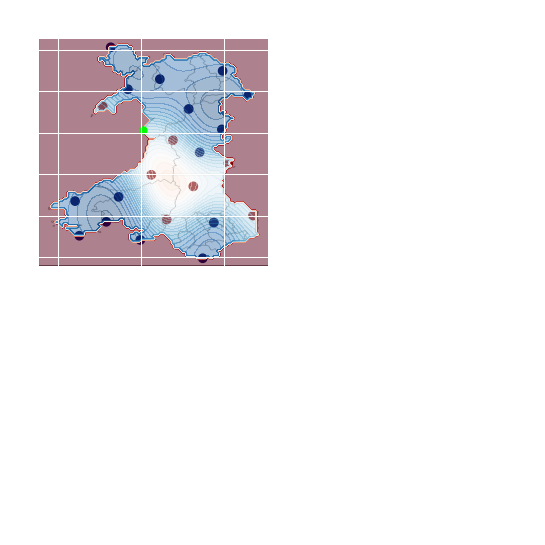

iteration  1
Accuracy is 0.5462411074793309
sim_anneal_isolated coord: (39.58660498358098, 44.9204223267824) distance: [[19.13044528]]
iteration  2
Accuracy is 0.6600653720438378
sim_anneal_isolated coord: (10.716081763577613, 36.33053134422378) distance: [[10.73410193]]
iteration  3
Accuracy is 0.7142857142857143
sim_anneal_isolated coord: (46.919525668771804, 10.071315611366659) distance: [[10.24761654]]
iteration  4
Accuracy is 0.5929628917515862
sim_anneal_isolated coord: (27.62050506490596, 28.22224981041619) distance: [[9.01083591]]
iteration  5
Accuracy is 0.5437415881561238
sim_anneal_isolated coord: (24.47099755972191, 42.93082400471737) distance: [[6.58839849]]
iteration  6
Accuracy is 0.6714093443568544
sim_anneal_isolated coord: (39.40727686136604, 30.814968152292913) distance: [[5.80679184]]
iteration  7
Accuracy is 0.7571620842145741
sim_anneal_isolated coord: (12.63580319807933, 50.600588504991784) distance: [[6.2210567]]
iteration  8
Accuracy is 0.7856181503557008
sim_a

<IPython.core.display.Javascript object>


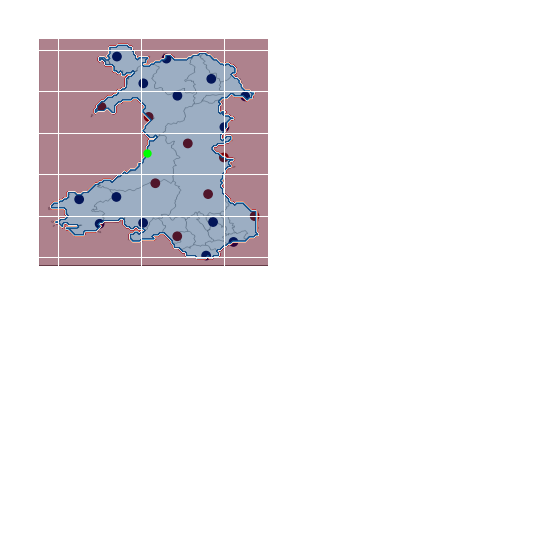

iteration  1
Accuracy is 0.6198807921553547
sim_anneal_isolated coord: (5.033550333460806, 13.9906987124527) distance: [[14.71217284]]
iteration  2
Accuracy is 0.6639107863872332
sim_anneal_isolated coord: (35.61433473943818, 0.4286692307797004) distance: [[12.86264913]]
iteration  3
Accuracy is 0.6479523168621419
sim_anneal_isolated coord: (14.133788077057076, 48.371354047205614) distance: [[8.23041836]]
iteration  4
Accuracy is 0.6412228417611998
sim_anneal_isolated coord: (26.053350744423387, 47.87770152140368) distance: [[5.48653707]]
iteration  5
Accuracy is 0.6394924053066718
sim_anneal_isolated coord: (20.438889216227246, 8.316199756177864) distance: [[2.79272218]]
iteration  6
Accuracy is 0.6362238031147857
sim_anneal_isolated coord: (14.005141202908419, 14.551326098213975) distance: [[4.25955398]]
iteration  7
Accuracy is 0.635839261680446
sim_anneal_isolated coord: (9.962377019584407, 8.087654581866966) distance: [[2.44482722]]
iteration  8
Accuracy is 0.635839261680446
sim_a

<IPython.core.display.Javascript object>


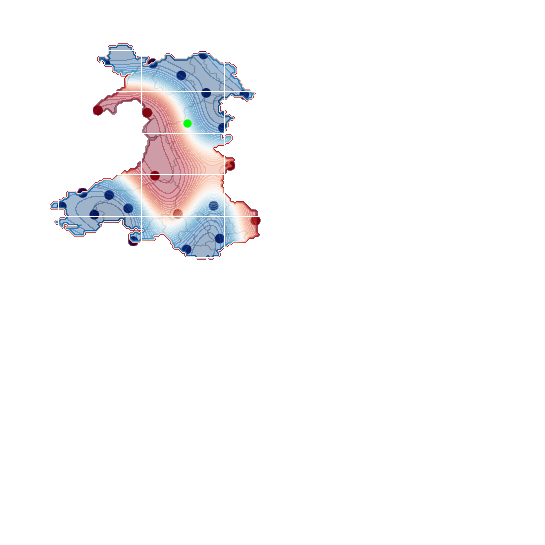

iteration  1
Accuracy is 0.40626802537973467
sim_anneal_isolated coord: (35.018333070424404, 48.88707179204644) distance: [[15.74447686]]
iteration  2
Accuracy is 0.6890982503364738
sim_anneal_isolated coord: (0.8379916921245014, 12.256647189373982) distance: [[11.18550348]]
iteration  3
Accuracy is 0.6767929244376082
sim_anneal_isolated coord: (11.310885912526, 46.678086384563585) distance: [[8.41824775]]
iteration  4
Accuracy is 0.6660257642761007
sim_anneal_isolated coord: (39.678526522150854, 31.18572791849058) distance: [[5.20284219]]
iteration  5
Accuracy is 0.6552586041145934
sim_anneal_isolated coord: (35.628157013858186, 39.6171182878324) distance: [[3.2919496]]
iteration  6
Accuracy is 0.6550663333974236
sim_anneal_isolated coord: (22.755442495067786, 46.670021124653935) distance: [[3.08363383]]
iteration  7
Accuracy is 0.6523745433570467
sim_anneal_isolated coord: (29.627168184914655, 43.8070495255726) distance: [[2.46375747]]
iteration  8
Accuracy is 0.6523745433570467
sim_

<IPython.core.display.Javascript object>


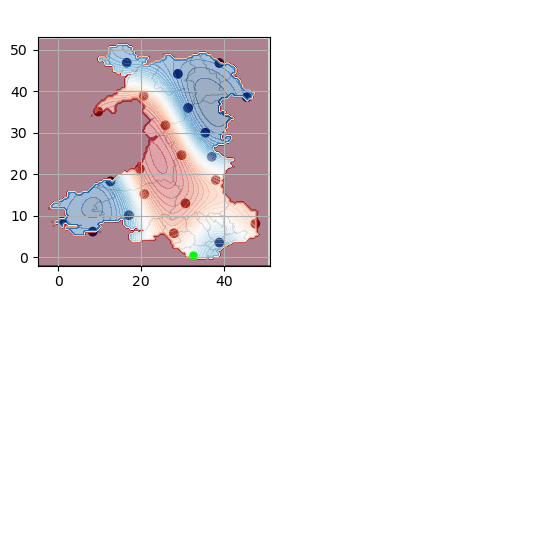

iteration  1
Accuracy is 0.5696981349740434
sim_anneal_isolated coord: (0.9061497628079032, 8.570370049594093) distance: [[15.02919874]]
iteration  2
Accuracy is 0.7129398192655259
sim_anneal_isolated coord: (25.799839851209416, 31.82263969529928) distance: [[7.95013773]]
iteration  3
Accuracy is 0.5935397039030955
sim_anneal_isolated coord: (38.79259574761238, 46.81722563342914) distance: [[9.9202988]]
iteration  4
Accuracy is 0.8111901557392809
sim_anneal_isolated coord: (47.47643136620887, 8.125953310692367) distance: [[7.72258497]]
iteration  5
Accuracy is 0.7033262834070371
sim_anneal_isolated coord: (17.029814706815074, 10.162088512435698) distance: [[6.44331897]]
iteration  6
Accuracy is 0.7588925206691021
sim_anneal_isolated coord: (9.649448171424336, 35.12014411481964) distance: [[5.985964]]
iteration  7
Accuracy is 0.7485099019419342
sim_anneal_isolated coord: (27.8440005072535, 5.799284015148955) distance: [[2.18316423]]
iteration  8
Accuracy is 0.7337050567198615
sim_anneal

<IPython.core.display.Javascript object>


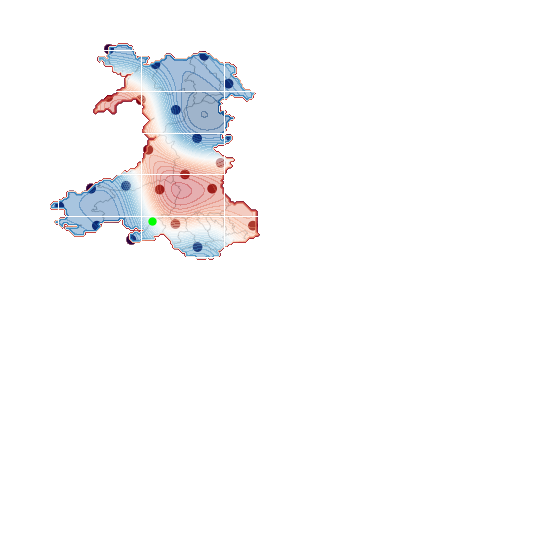

iteration  1
Accuracy is 0.635070178811767
sim_anneal_isolated coord: (0.2604800699756695, 12.293708608719951) distance: [[12.24456915]]
iteration  2
Accuracy is 0.7258219573159008
sim_anneal_isolated coord: (12.036991940421508, 38.629989958031544) distance: [[11.32534192]]
iteration  3
Accuracy is 0.6800615266294944
sim_anneal_isolated coord: (46.89473981399799, 7.637393182743297) distance: [[12.0519368]]
iteration  4
Accuracy is 0.5550855604691406
sim_anneal_isolated coord: (41.54795102164866, 29.026900574153544) distance: [[9.46863213]]
iteration  5
Accuracy is 0.6775620073062872
sim_anneal_isolated coord: (28.309305724464647, 35.52488725346284) distance: [[6.98634075]]
iteration  6
Accuracy is 0.6441069025187464
sim_anneal_isolated coord: (23.41679233584926, 46.534312296245034) distance: [[5.65037758]]
iteration  7
Accuracy is 0.7015958469525091
sim_anneal_isolated coord: (33.553442440312445, 2.487559811473286) distance: [[4.85933103]]
iteration  8
Accuracy is 0.7244760622957124
si

<IPython.core.display.Javascript object>


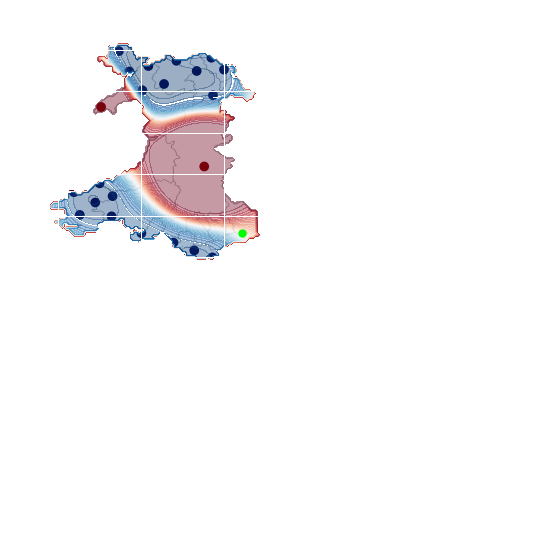

iteration  1
Accuracy is 0.5514324168429148
sim_anneal_isolated coord: (14.593159784461257, 49.67577538389674) distance: [[17.28563335]]
iteration  2
Accuracy is 0.6783310901749664
sim_anneal_isolated coord: (39.91366238063298, 45.22691937884358) distance: [[10.67509612]]
iteration  3
Accuracy is 0.6577581234378004
sim_anneal_isolated coord: (37.14369587486544, 0.010749876963029759) distance: [[7.17484863]]
iteration  4
Accuracy is 0.6423764660642184
sim_anneal_isolated coord: (28.470404635230448, 47.3520453769134) distance: [[4.8337011]]
iteration  5
Accuracy is 0.637569698134974
sim_anneal_isolated coord: (20.262248609137863, 40.221801986814896) distance: [[4.459478]]
iteration  6
Accuracy is 0.635070178811767
sim_anneal_isolated coord: (21.70488233550648, 46.095725773493314) distance: [[2.48235104]]
iteration  7
Accuracy is 0.635070178811767
sim_anneal_isolated coord: (20.02815890065996, 5.826737001655547) distance: [[2.05565937]]
iteration  8
Accuracy is 0.6294943280138435
sim_anne

<IPython.core.display.Javascript object>


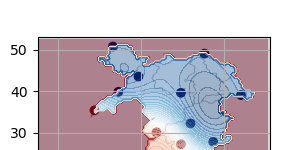

iteration  1
Accuracy is 0.5945010574889444
sim_anneal_isolated coord: (46.521438041184496, 5.699338761615623) distance: [[14.81276777]]
iteration  2
Accuracy is 0.46029609690444145
sim_anneal_isolated coord: (44.00860124067961, 39.09201001737326) distance: [[11.30073389]]
iteration  3
Accuracy is 0.6362238031147857
sim_anneal_isolated coord: (3.355461363180095, 6.44913610420143) distance: [[11.37269846]]
iteration  4
Accuracy is 0.6975581618919439
sim_anneal_isolated coord: (41.15160632997804, 22.49240474085513) distance: [[7.50069543]]
iteration  5
Accuracy is 0.6983272447606229
sim_anneal_isolated coord: (28.00916523133303, 3.519439073958687) distance: [[8.48829111]]
iteration  6
Accuracy is 0.7383195539319362
sim_anneal_isolated coord: (31.833859384526704, 32.25412856484225) distance: [[5.79058904]]
iteration  7
Accuracy is 0.716208421457412
sim_anneal_isolated coord: (8.72468869751501, 35.41868537479468) distance: [[5.87203427]]
iteration  8
Accuracy is 0.7285137473562776
sim_anne

<IPython.core.display.Javascript object>


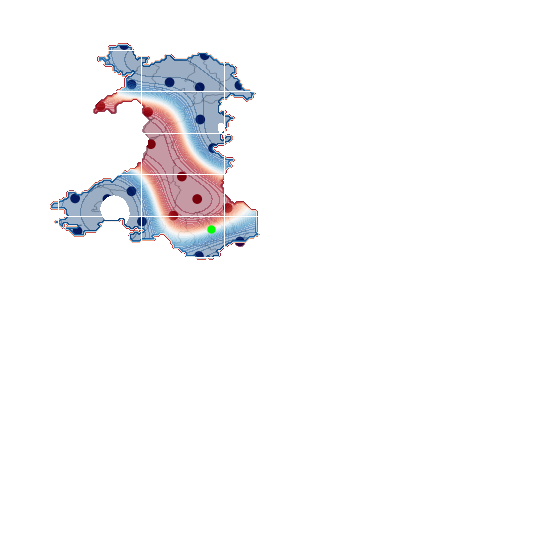

iteration  1
Accuracy is 0.5612382234185733
sim_anneal_isolated coord: (15.87987068593808, 51.13267379005153) distance: [[23.09681812]]
iteration  2
Accuracy is 0.6173812728321476
sim_anneal_isolated coord: (43.6430762597025, 41.46612889319903) distance: [[13.21166223]]
iteration  3
Accuracy is 0.6139203999230917
sim_anneal_isolated coord: (22.306497878182626, 27.262700819903948) distance: [[7.98381161]]
iteration  4
Accuracy is 0.8092674485675831
sim_anneal_isolated coord: (26.812280105842678, 42.15581916259046) distance: [[7.07286177]]
iteration  5
Accuracy is 0.7337050567198615
sim_anneal_isolated coord: (20.165636564885297, 8.635923125775804) distance: [[6.50467607]]
iteration  6
Accuracy is 0.6852528359930783
sim_anneal_isolated coord: (11.846304809685101, 14.04619372039597) distance: [[4.96191265]]
iteration  7
Accuracy is 0.6791001730436454
sim_anneal_isolated coord: (35.31730406923948, 48.70538805041738) distance: [[4.14132263]]
iteration  8
Accuracy is 0.676023841568929
sim_an

<IPython.core.display.Javascript object>


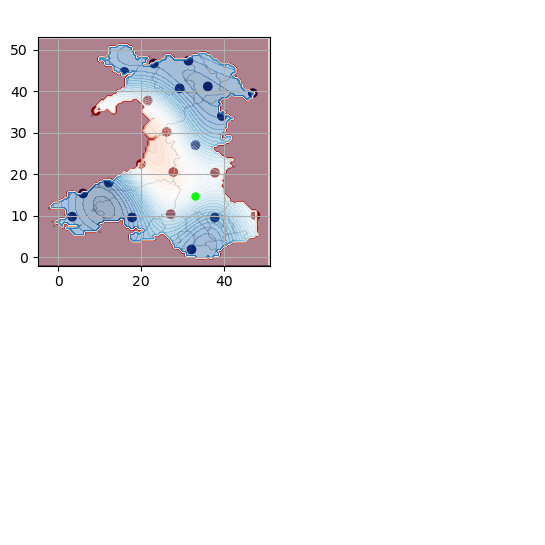

iteration  1
Accuracy is 0.48202268794462605
sim_anneal_isolated coord: (32.0921040223144, 1.9024830981039962) distance: [[14.47221353]]
iteration  2
Accuracy is 0.6939050182657182
sim_anneal_isolated coord: (3.3467028137901735, 9.803829648170709) distance: [[13.82569934]]
iteration  3
Accuracy is 0.6833301288213806
sim_anneal_isolated coord: (46.855297443224195, 39.56842275573143) distance: [[7.75629362]]
iteration  4
Accuracy is 0.6714093443568544
sim_anneal_isolated coord: (17.793292687196026, 9.612802992538505) distance: [[4.8374015]]
iteration  5
Accuracy is 0.6633339742357239
sim_anneal_isolated coord: (47.49805972757915, 10.095918891290525) distance: [[3.15487269]]
iteration  6
Accuracy is 0.7156316093059027
sim_anneal_isolated coord: (31.355573229589865, 47.36637346144654) distance: [[6.97442492]]
iteration  7
Accuracy is 0.7100557585079792
sim_anneal_isolated coord: (27.074202803143084, 10.416368641919933) distance: [[4.48461327]]
iteration  8
Accuracy is 0.7565852720630648
si

<IPython.core.display.Javascript object>


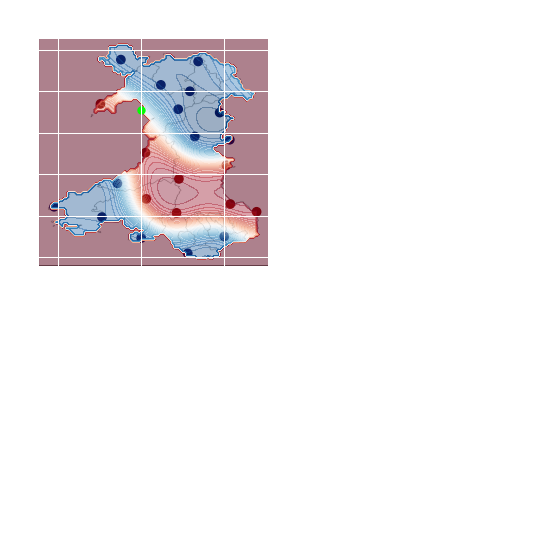

iteration  1
Accuracy is 0.5556623726206499
sim_anneal_isolated coord: (39.98560823983718, 5.044798238102441) distance: [[12.54399801]]
iteration  2
Accuracy is 0.645260526821765
sim_anneal_isolated coord: (-1.0112531217113334, 12.194942808681667) distance: [[12.57938339]]
iteration  3
Accuracy is 0.6327629302057297
sim_anneal_isolated coord: (15.07897808234746, 47.633103105559094) distance: [[8.58937648]]
iteration  4
Accuracy is 0.6264179965391271
sim_anneal_isolated coord: (33.68818621334472, 47.18638219131914) distance: [[5.98627472]]
iteration  5
Accuracy is 0.6241107479330897
sim_anneal_isolated coord: (19.980964837153326, 4.661666863389412) distance: [[4.21496797]]
iteration  6
Accuracy is 0.6206498750240338
sim_anneal_isolated coord: (40.48948757568739, 22.220503030146034) distance: [[3.05678173]]
iteration  7
Accuracy is 0.6241107479330897
sim_anneal_isolated coord: (24.715028100500398, 41.54541965169652) distance: [[5.12141278]]
iteration  8
Accuracy is 0.6237262064987502
sim

<IPython.core.display.Javascript object>


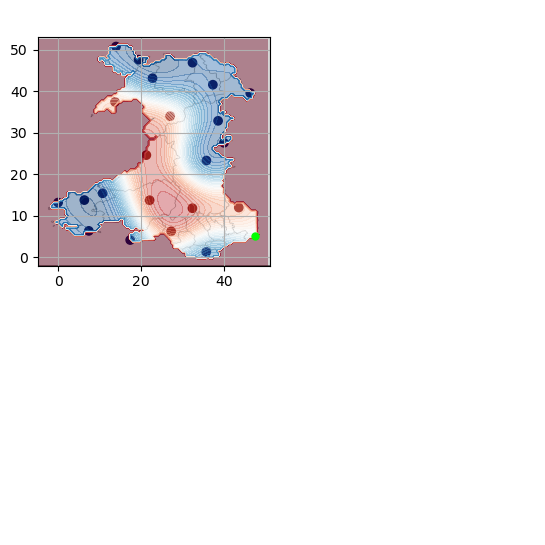

iteration  1
Accuracy is 0.5716208421457412
sim_anneal_isolated coord: (35.648171576202266, 1.319277839707544) distance: [[21.1436402]]
iteration  2
Accuracy is 0.6148817535089406
sim_anneal_isolated coord: (7.362284418624444, 6.3815676701890816) distance: [[13.03533337]]
iteration  3
Accuracy is 0.6187271678523361
sim_anneal_isolated coord: (35.68093386407722, 23.323673110284) distance: [[7.47277092]]
iteration  4
Accuracy is 0.6198807921553547
sim_anneal_isolated coord: (22.000986567742174, 13.756939798887093) distance: [[5.22693757]]
iteration  5
Accuracy is 0.639300134589502
sim_anneal_isolated coord: (46.24772470784165, 39.56870155250453) distance: [[7.61536625]]
iteration  6
Accuracy is 0.6408383003268602
sim_anneal_isolated coord: (43.48087926046046, 12.00379813615109) distance: [[5.6370434]]
iteration  7
Accuracy is 0.6673716592962892
sim_anneal_isolated coord: (26.937600701919102, 34.01318994568422) distance: [[6.24366205]]
iteration  8
Accuracy is 0.702557200538358
sim_anneal

<IPython.core.display.Javascript object>


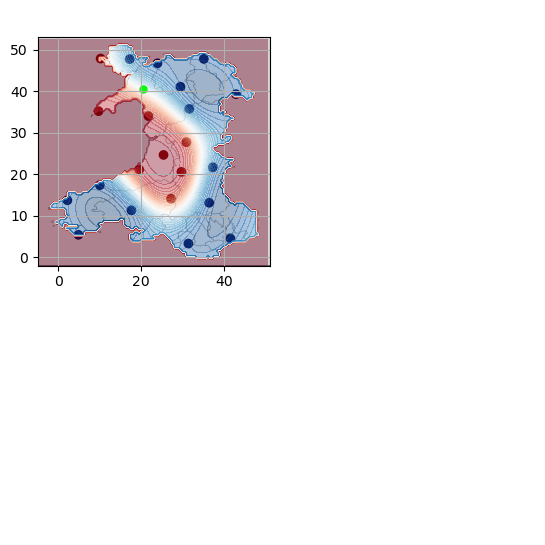

iteration  1
Accuracy is 0.4226110363391655
sim_anneal_isolated coord: (42.81336421799792, 39.31549113492609) distance: [[16.67919026]]
iteration  2
Accuracy is 0.6216112286098827
sim_anneal_isolated coord: (36.341727564227334, 13.146604501492519) distance: [[8.587027]]
iteration  3
Accuracy is 0.6243030186502596
sim_anneal_isolated coord: (30.885422307685293, 27.737650610457685) distance: [[5.72616212]]
iteration  4
Accuracy is 0.6923668525283599
sim_anneal_isolated coord: (23.900747337434982, 46.74190221864082) distance: [[8.32020159]]
iteration  5
Accuracy is 0.6729475100942126
sim_anneal_isolated coord: (31.33077218749933, 3.3225917680820083) distance: [[5.51409331]]
iteration  6
Accuracy is 0.6698711786194963
sim_anneal_isolated coord: (35.07026402247366, 47.8030480840061) distance: [[5.34118162]]
iteration  7
Accuracy is 0.6675639300134589
sim_anneal_isolated coord: (27.160218797429934, 14.120574538342892) distance: [[4.05846469]]
iteration  8
Accuracy is 0.7219765429725052
sim_a

<IPython.core.display.Javascript object>


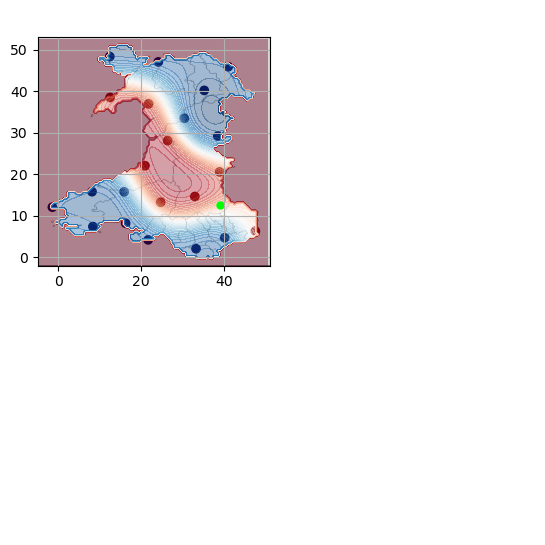

iteration  1
Accuracy is 0.6021918861757354
sim_anneal_isolated coord: (-1.4110572686277978, 12.094723012512421) distance: [[17.20315583]]
iteration  2
Accuracy is 0.706018073447414
sim_anneal_isolated coord: (12.494758141900329, 38.514021420026275) distance: [[10.25572544]]
iteration  3
Accuracy is 0.6912132282253413
sim_anneal_isolated coord: (15.88144644961408, 15.791691977264362) distance: [[8.37546379]]
iteration  4
Accuracy is 0.6742934051144011
sim_anneal_isolated coord: (47.4659895585668, 6.316535222821025) distance: [[6.83971511]]
iteration  5
Accuracy is 0.677754278023457
sim_anneal_isolated coord: (26.351210902429422, 28.11489001535307) distance: [[6.72687288]]
iteration  6
Accuracy is 0.6962122668717554
sim_anneal_isolated coord: (38.42765108418085, 29.204885612647676) distance: [[5.09124265]]
iteration  7
Accuracy is 0.7642761007498557
sim_anneal_isolated coord: (24.102955235149558, 47.084620716591616) distance: [[6.43799432]]
iteration  8
Accuracy is 0.7963853105172082
si

<IPython.core.display.Javascript object>


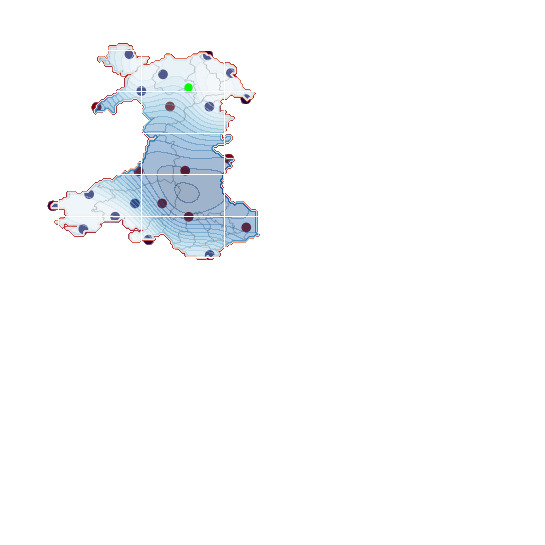

iteration  1
Accuracy is 0.500865218227264
sim_anneal_isolated coord: (36.032522270517745, 48.64917712689006) distance: [[16.24819385]]
iteration  2
Accuracy is 0.6587194770236493
sim_anneal_isolated coord: (45.28208945064368, 7.2069439336752605) distance: [[14.64607286]]
iteration  3
Accuracy is 0.7650451836185349
sim_anneal_isolated coord: (17.151350588706663, 48.932593332496765) distance: [[9.19455257]]
iteration  4
Accuracy is 0.6758315708517593
sim_anneal_isolated coord: (26.906560580081692, 36.335424681495475) distance: [[7.10126196]]
iteration  5
Accuracy is 0.6771774658719477
sim_anneal_isolated coord: (21.748025135942015, 4.26326028398508) distance: [[8.17482523]]
iteration  6
Accuracy is 0.6989040569121323
sim_anneal_isolated coord: (9.24775933256116, 36.1341166722215) distance: [[6.93769313]]
iteration  7
Accuracy is 0.6767929244376082
sim_anneal_isolated coord: (41.072063932663475, 23.7100492013715) distance: [[7.59509824]]
iteration  8
Accuracy is 0.6414151124783696
sim_an

<IPython.core.display.Javascript object>


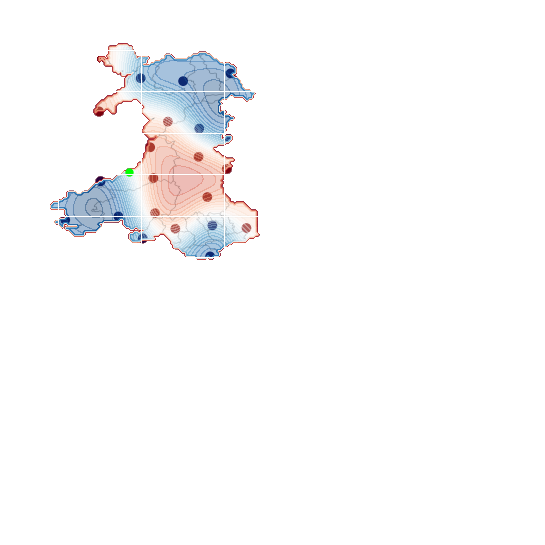

iteration  1
Accuracy is 0.49701980388386846
sim_anneal_isolated coord: (36.5788692488608, 0.23119542601301823) distance: [[21.35599694]]
iteration  2
Accuracy is 0.588925206691021
sim_anneal_isolated coord: (1.6841789098913011, 9.014060127915721) distance: [[16.34550676]]
iteration  3
Accuracy is 0.5971928475293213
sim_anneal_isolated coord: (22.90020336978027, 19.109462245106386) distance: [[7.95163566]]
iteration  4
Accuracy is 0.6944818304172274
sim_anneal_isolated coord: (40.95445565723695, 28.67267157649039) distance: [[8.53386717]]
iteration  5
Accuracy is 0.6702557200538358
sim_anneal_isolated coord: (35.90634875326707, 14.51612553839691) distance: [[5.81215928]]
iteration  6
Accuracy is 0.746971736204576
sim_anneal_isolated coord: (14.483965344884592, 9.855937652553795) distance: [[5.98382866]]
iteration  7
Accuracy is 0.7661988079215536
sim_anneal_isolated coord: (26.398872790826555, 32.693396592854754) distance: [[5.20973296]]
iteration  8
Accuracy is 0.8425302826379543
sim_

<IPython.core.display.Javascript object>


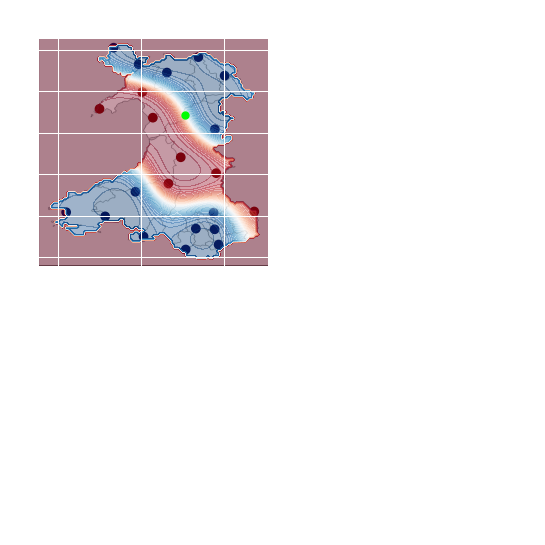

iteration  1
Accuracy is 0.39030955585464333
sim_anneal_isolated coord: (13.340282522117278, 50.5012828995111) distance: [[15.47369476]]
iteration  2
Accuracy is 0.7023649298211883
sim_anneal_isolated coord: (1.9032075646308488, 10.878903799402766) distance: [[14.62353979]]
iteration  3
Accuracy is 0.6806383387810037
sim_anneal_isolated coord: (40.07333579058107, 43.77031804204346) distance: [[7.83915447]]
iteration  4
Accuracy is 0.6648721399730821
sim_anneal_isolated coord: (20.54440244259767, 5.022881304421174) distance: [[5.32534067]]
iteration  5
Accuracy is 0.6541049798115747
sim_anneal_isolated coord: (26.16659681578057, 44.51202625261237) distance: [[4.54485716]]
iteration  6
Accuracy is 0.6496827533166699
sim_anneal_isolated coord: (30.689750669913785, 1.8924288438473404) distance: [[3.25609696]]
iteration  7
Accuracy is 0.6483368582964815
sim_anneal_isolated coord: (38.609231223923814, 3.067318644211917) distance: [[2.47482077]]
iteration  8
Accuracy is 0.6481445875793117
sim

<IPython.core.display.Javascript object>


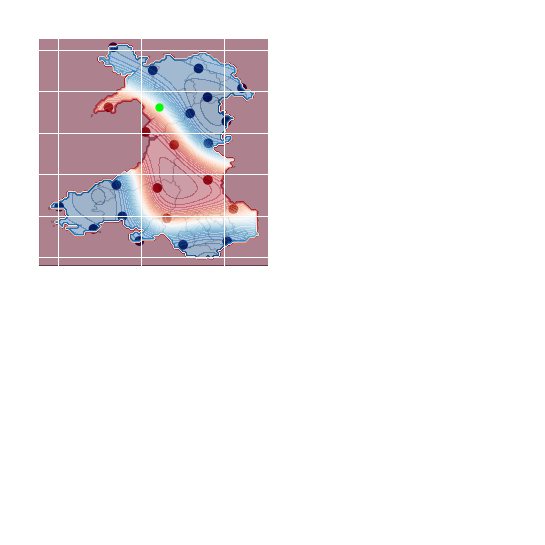

iteration  1
Accuracy is 0.5673908863680062
sim_anneal_isolated coord: (40.70186909472642, 3.861872242333325) distance: [[16.03710713]]
iteration  2
Accuracy is 0.6312247644683715
sim_anneal_isolated coord: (0.22059750177683846, 12.21095298890386) distance: [[13.18938087]]
iteration  3
Accuracy is 0.6223803114785618
sim_anneal_isolated coord: (19.532226826554695, 3.9429173660622587) distance: [[8.02057988]]
iteration  4
Accuracy is 0.6194962507210152
sim_anneal_isolated coord: (13.25770072028578, 50.60252372306032) distance: [[6.52531138]]
iteration  5
Accuracy is 0.6175735435493175
sim_anneal_isolated coord: (44.26598812281323, 40.75993575305837) distance: [[5.08142069]]
iteration  6
Accuracy is 0.6173812728321476
sim_anneal_isolated coord: (33.80304617383687, 45.500084012289875) distance: [[4.9890863]]
iteration  7
Accuracy is 0.6173812728321476
sim_anneal_isolated coord: (40.48482986885499, 32.73911472061435) distance: [[3.0389043]]
iteration  8
Accuracy is 0.6173812728321476
sim_an

<IPython.core.display.Javascript object>


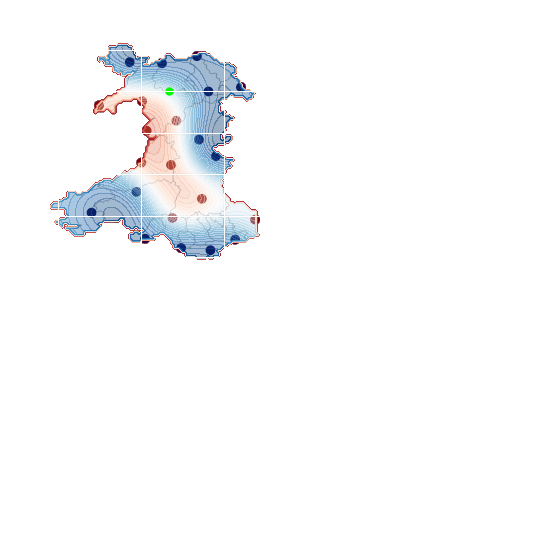

iteration  1
Accuracy is 0.5654681791963084
sim_anneal_isolated coord: (17.198966773942445, 47.01886384761895) distance: [[18.61165996]]
iteration  2
Accuracy is 0.6792924437608152
sim_anneal_isolated coord: (43.9937049620341, 40.98924539792568) distance: [[12.35013547]]
iteration  3
Accuracy is 0.6579503941549703
sim_anneal_isolated coord: (28.425290506459397, 32.9178952746451) distance: [[5.98666302]]
iteration  4
Accuracy is 0.7479330897904249
sim_anneal_isolated coord: (20.896948294910132, 4.508099932000398) distance: [[7.02989284]]
iteration  5
Accuracy is 0.7281292059219381
sim_anneal_isolated coord: (18.825977940985698, 15.778543435799083) distance: [[5.55541809]]
iteration  6
Accuracy is 0.7056335320130744
sim_anneal_isolated coord: (9.846894125586758, 36.587575943881) distance: [[4.16966209]]
iteration  7
Accuracy is 0.7190924822149587
sim_anneal_isolated coord: (33.39225065047357, 48.4633447298481) distance: [[5.51142859]]
iteration  8
Accuracy is 0.7288982887906172
sim_annea

In [8]:
from random import randint
import time

valid_seeds = [4,27,12,15,17,21,23,24,25,28,31,32,35,36,37,41,42,43,45,48,420]

Results = []

for j in range(len(valid_seeds)):
    
    random.seed(valid_seeds[j])

    print('experiment: ',j)                            

    num = 100
    x = np.linspace(-5, 51, num)
    y = np.linspace(-2, 53, num)
    global landpoints 
    landpoints = []

    for i in range(num):
        for j in range(num):
            if wales.contains_points([(x[i],y[j])]):
                landpoints.append([x[i],y[j]])

    landpoints = np.asarray(landpoints, dtype=np.float32)

    i=0 
    coords = []

    for i in range(numcoords):
        value = randint(0, landpoints.size/2)
        coords.append((landpoints[value][0],
                            landpoints[value][1],
                            braninColor(landpoints[value],threshold)))
        i+=1

    global fig1,ax
    fig1, ax = plt.subplots(figsize = (3,3))
    ax.set_xlim(-5,51)
    ax.set_ylim(-2,53)
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic')
    # plt.axis("off")
    plt.grid()
    # cid = fig1.canvas.mpl_connect('button_press_event', Helicopter)

    fig1.show()
    fig1.canvas.draw()

    global accuracyArray
    accuracyArray = []

    for i in range(maxiter):
        plt.pause(1)
        print('iteration ',i+1)
    #     print('Calculating Model... ')
        calculateModel()
        plt.pause(1)
        fig1.canvas.draw()    
        Accuracy()
    #     print('Finding Isolated Point')
        if(i!=maxiter):
                     #0 for 0.5, 1 for isolated, 2 for random

            if(selection_model == 0):    
                nextpoint = find0_5()
            elif(selection_model==1):
                nextpoint=find_isolated_point()
            elif(selection_model==2):
                nextpoint = random_point()
            elif(selection_model==3):
                nextpoint = best()
            elif(selection_model==4):
                nextpoint = sim_anneal_best()
            plt.pause(1)
            fig1.canvas.draw()
            coords.append((nextpoint[0], nextpoint[1], braninColor(nextpoint,threshold)))  
            plt.pause(1)
            fig1.canvas.draw()

    plt.close()
    
    Results.append(accuracyArray)
    
    

In [9]:
print('Highest Accuracy =',"{:.2f}".format((max(accuracyArray)*100)),'%')
print('Improvement is =', "{:.2f}".format((max(accuracyArray)-accuracyArray[0])*100),'%')

Highest Accuracy = 86.71 %
Improvement is = 30.17 %


In [10]:
np.savetxt('braninBestSimAnnealrbf', Results)